In [24]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit.visualization import plot_histogram
from math import pi
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import numpy as np
import random
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from time import time
from qiskit.circuit.library.standard_gates import RYGate, RYYGate

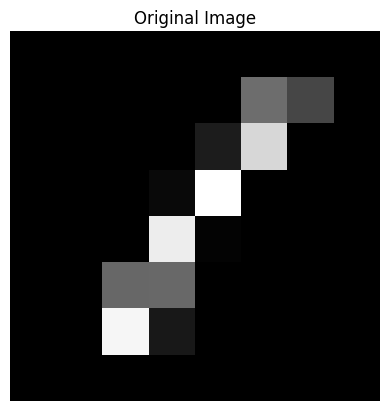

In [25]:
# Read the CSV file. 
# (Assuming the CSV has a label in the first column and pixel values in the remaining 64 columns, for an 8x8 image.)
dataset = pd.read_csv('../frqi/website/static/mnist_dataset.csv')

# Select the first image, ignoring the label column.
# Adjust slicing if your file has a different format.
image_data = dataset.to_numpy()[0, 1:]
# Reshape to an 8x8 array and ensure pixel values are integers (0-255)
image = image_data.reshape(8, 8).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [26]:
# Normalize pixel values to 8-bit integers (0-255)
pixel_values = image.flatten()

# Declare the Quantum and Classical registers
position_qubits = QuantumRegister(6, 'pos')  # 6 qubits for 64 positions
intensity_qubits = QuantumRegister(8, 'int')  # 8 qubits for intensity (8-bit grayscale)
classical_bits = ClassicalRegister(14, 'c')  # For measurement
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)

# Function to apply Hadamard gates to position qubits
def hadamard(circ, n):
    for i in n:
        circ.h(i)

def encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_vals):
    n = len(position_qubits)
    m = len(intensity_qubits)

    for idx, pixel in enumerate(pixel_vals):
        # big-endian index & intensity strings
        bin_idx       = format(idx,   f'0{n}b')  
        intensity_bin = format(pixel, f'0{m}b')

        # 1) “select” the basis state |idx⟩ by flipping pos-qubits where bit=0
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])

        # 2) for each ‘1’ in the intensity, apply an mcx onto the reversed qubit
        for j, bit in enumerate(intensity_bin):
            if bit == '1':
                circ.mcx(
                    control_qubits=position_qubits,
                    target_qubit=intensity_qubits[m - 1 - j]
                )

        # 3) uncompute the X’s so the pos-register is clean for the next idx
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])


# NEQR function to encode the image
def neqr(circ, position_qubits, intensity_qubits, pixel_values):
    # Apply Hadamard to position qubits to create superposition
    circ.h(position_qubits)
    # Encode pixel values
    encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values)


# Apply NEQR encoding
neqr(qc, position_qubits, intensity_qubits, pixel_values)

# Measure all qubits
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# Visualize the circuit
# qc.draw('mpl')

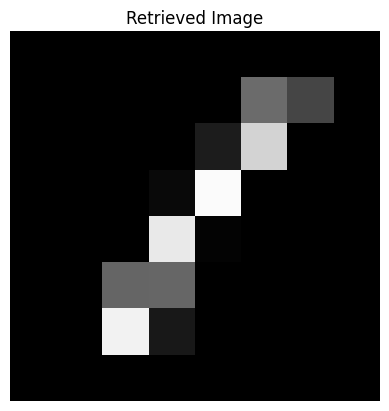

In [27]:
from collections import defaultdict
from qiskit import transpile
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# 1) Transpile & run
simulator = AerSimulator()
t_qc = transpile(qc, simulator)
result = simulator.run(t_qc, shots=180).result()
counts = result.get_counts()

# 2) Build a dict: position → { intensity → votes }
pos2counts = defaultdict(lambda: defaultdict(int))
for bitstr, cnt in counts.items():
    # MSB-first: first 8 bits = intensity, last 6 bits = position
    intensity = int(bitstr[:8],  2)
    position  = int(bitstr[8:],   2)
    pos2counts[position][intensity] += cnt

# 3) Winner-takes-all decode
flat = np.zeros(64, dtype=int)
for pos, idict in pos2counts.items():
    # pick the intensity with the highest vote-count
    flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]

# 4) Reshape back to 8×8 and plot
retrieve_image = flat.reshape((8,8)).astype(np.uint8)
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title("Retrieved Image")
plt.axis('off')
plt.show()


In [29]:
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn.functional as F

def weighted_mae(original, retrieved):
    orig = torch.tensor(original, dtype=torch.float32) / 255.0
    retr = torch.tensor(retrieved, dtype=torch.float32) / 255.0
    mask = (orig > 0)
    orig_masked = orig[mask]
    retr_masked = retr[mask]
    if orig_masked.numel() == 0:
        return 0.0
    loss = F.l1_loss(orig_masked, retr_masked)
    return 1.0 - loss.item()

def ssim_fidelity(original, retrieved):
    return ssim(original, retrieved, data_range=255)

In [30]:
print("Choose fidelity metric:")
print("1: SSIM")
print("2: Weighted MAE")
choice = input("Enter 1 or 2: ").strip()
if choice == "1":
    fidelity_func = ssim_fidelity
    metric_name = "SSIM"
    print("Using SSIM for fidelity.")
elif choice == "2":
    fidelity_func = weighted_mae
    metric_name = "Weighted MAE"
    print("Using weighted MAE for fidelity.")
else:
    raise ValueError("Invalid choice. Please enter 1 or 2.")

Choose fidelity metric:
1: SSIM
2: Weighted MAE
Using weighted MAE for fidelity.


In [31]:
simulator = AerSimulator()
shot_counts = np.unique(np.round(np.logspace(np.log10(100), np.log10(2000), num=10)).astype(int))
num_images = 10  # Number of random images to use
total_images = len(dataset)
random_indices = sorted(random.sample(range(total_images), num_images))

def fidelity_for_image_args(args):
    img_idx, shots = args
    print(f"  Image {img_idx} with {shots} shots...", flush=True)
    image_data = dataset.to_numpy()[img_idx, 1:]
    image = image_data.reshape(8, 8).astype(np.uint8)
    pixel_values = image.flatten()
    position_qubits = QuantumRegister(6, 'pos')
    intensity_qubits = QuantumRegister(8, 'int')
    classical_bits = ClassicalRegister(14, 'c')
    qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)
    neqr(qc, position_qubits, intensity_qubits, pixel_values)
    qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])
    t_qc = transpile(qc, simulator)
    result = simulator.run(t_qc, shots=int(shots)).result()
    counts = result.get_counts()
    pos2counts = defaultdict(lambda: defaultdict(int))
    for bitstr, cnt in counts.items():
        intensity = int(bitstr[:8],  2)
        position  = int(bitstr[8:], 2)
        pos2counts[position][intensity] += cnt
    flat = np.zeros(64, dtype=int)
    for pos, idict in pos2counts.items():
        flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]
    retrieved_image = flat.reshape((8,8)).astype(np.uint8)
    fid = fidelity_func(image, retrieved_image)
    print(f"    -> Fidelity: {fid:.4f}", flush=True)
    return fid

fidelities = []
from concurrent.futures import ThreadPoolExecutor
for shots in shot_counts:
    print(f"Processing {shots} shots...")
    args = [(img_idx, shots) for img_idx in random_indices]
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(fidelity_for_image_args, args))
    avg_fid = np.mean(results)
    fidelities.append(avg_fid)
    print(f"Shots: {shots}, Avg {metric_name}: {avg_fid:.4f}")

Processing 100 shots...
  Image 1404 with 100 shots...
  Image 9220 with 100 shots...
  Image 13033 with 100 shots...


  Image 14850 with 100 shots...
  Image 21724 with 100 shots...
  Image 28230 with 100 shots...
  Image 28685 with 100 shots...
  Image 28878 with 100 shots...  Image 33746 with 100 shots...

  Image 35483 with 100 shots...
    -> Fidelity: 0.8711
    -> Fidelity: 0.8314
    -> Fidelity: 0.8039
    -> Fidelity: 0.7220
    -> Fidelity: 0.8845
    -> Fidelity: 1.0000    -> Fidelity: 0.9011

    -> Fidelity: 0.8493
    -> Fidelity: 0.9553
    -> Fidelity: 0.9126
Shots: 100, Avg Weighted MAE: 0.8731
Processing 139 shots...
  Image 1404 with 139 shots...
  Image 9220 with 139 shots...
  Image 13033 with 139 shots...
  Image 14850 with 139 shots...  Image 21724 with 139 shots...
  Image 28230 with 139 shots...
  Image 28685 with 139 shots...

  Image 28878 with 139 shots...
  Image 33746 with 139 shots...
  Image 35483 with 139 shots...
    -> Fidelity: 0.9063
    -> Fidelity: 0.9769
    -> Fidelity: 0.9821
    -> Fidelity: 0.9594
    -> Fidelity: 0.8924
    -> Fidelity: 0.9240
    -> Fideli

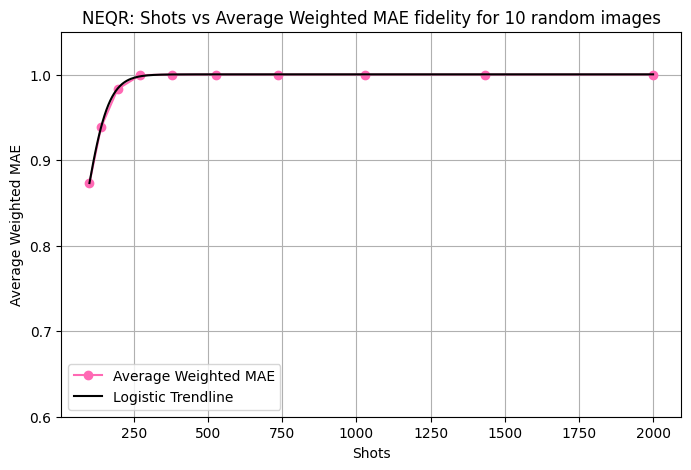

In [33]:
from scipy.optimize import curve_fit

def logistic(x, L, x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

p0 = [1, np.median(shot_counts), 0.01, 0]
plt.figure(figsize=(8,5))
plt.plot(shot_counts, fidelities, marker='o', color='hotpink', label=f'Average {metric_name}')
try:
    params, _ = curve_fit(logistic, shot_counts, fidelities, p0, maxfev=10000)
    x_fit = np.linspace(min(shot_counts), max(shot_counts), 300)
    plt.plot(x_fit, logistic(x_fit, *params), color='black', linestyle='-', label='Logistic Trendline')
except Exception as e:
    print("Logistic fit failed:", e)

plt.title(f"NEQR: Shots vs Average {metric_name} fidelity for 10 random images")
plt.xlabel("Shots")
plt.ylabel(f"Average {metric_name}")
plt.grid(True)
plt.ylim(0.6, 1.05)
plt.legend()
plt.show()